## shared code

In [1]:
import os

if not os.path.exists("groundtruth-drosophila-vnc"):
    os.system("git clone https://github.com/unidesigner/groundtruth-drosophila-vnc")

raw_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "raw")
label_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "labels")

train_images_paths = os.listdir(raw_path)

print(f"{len(train_images_paths)} training images")

20 training images


In [2]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

raw_sources = raw_paths.product(flip_ud=[True, False], flip_lr=[True, False])
label_sources = label_paths.product(flip_ud=[True, False], flip_lr=[True, False])

2024-01-25 12:52:39.176796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np
from matplotlib import pyplot as plt


def select_labels(class_labels=None):
    def inner(gt_seg_image):
        gt_seg_image = gt_seg_image.copy()
        masked_gt_seg_imag = gt_seg_image * np.isin(gt_seg_image, class_labels).astype(
            np.uint8
        )
        replace = np.arange(len(class_labels)) + 1
        gt_seg_image_new_labels = np.select(
            [masked_gt_seg_imag == cl for cl in class_labels], replace
        ).astype(np.uint8)
        out = np.eye(len(class_labels) + 1)[gt_seg_image_new_labels.squeeze()]

        return out

    return inner

In [13]:
sources = dt.sources.Sources(raw_sources, label_sources)
im_pipeline = dt.LoadImage(sources.path) >> dt.NormalizeMinMax()
lab_pipeline = dt.LoadImage(sources.path) >> dt.Lambda(
    select_labels, class_labels=[255, 191]
)

pipeline = (
    (im_pipeline & lab_pipeline)
    #     >> dt.FlipLR(raw_sources.flip_lr)
    #     >> dt.FlipUD(raw_sources.flip_ud)
    #     >> dt.Crop(crop=(256, 256, None))
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

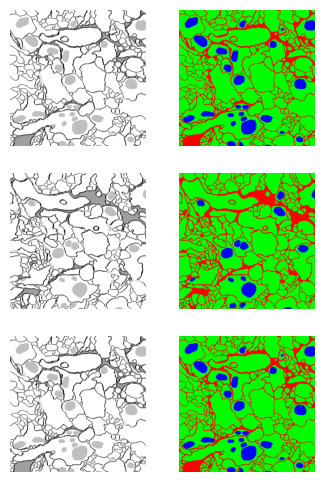

In [16]:
import matplotlib.pyplot as plt

idxs = np.random.choice(np.linspace(0, 19, 20).astype(int), 3)
fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i, idx in enumerate(idxs):
    image, label = pipeline([raw_sources[idx], label_sources[idx]])
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

## Track 1 (not working)

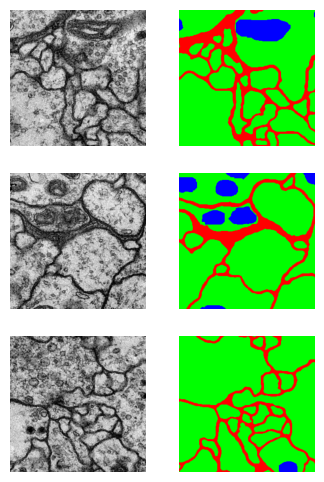

In [6]:
train_dataset = dt.pytorch.Dataset(pipeline, raw_sources)

# seems to work just fine here but it doesn't train
# loss gets stuck at ~0.7
fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i in range(3):
    image, label = train_dataset[i]
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

## Track 2 (works)

In [5]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, labelPaths, pipeline):
        self.imagePaths = imagePaths
        self.labelPaths = labelPaths
        self.pipeline = pipeline

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        image, label = pipeline([self.imagePaths[idx], self.labelPaths[idx]])

        return (image, label)

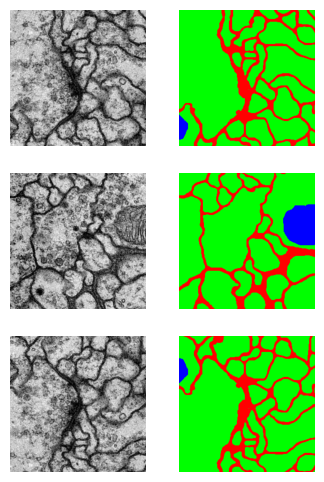

In [6]:
train_dataset = SegmentationDataset(raw_sources, label_sources, pipeline)

# seems to work too
fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i in range(3):
    image, label = train_dataset[i]
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

## shared part

In [7]:
from torch.utils.data import DataLoader

data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
import deeplay as dl
from torch.nn import Identity

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=3,
    out_activation=Identity(),
)

from torch.nn import CrossEntropyLoss


unet_regressor = dl.Regressor(
    model=unet,
    loss=CrossEntropyLoss(),
    optimizer=dl.Adam(),
).create()

unet_trainer = dl.Trainer(max_epochs=100, accelerator="auto")

unet_trainer.fit(unet_regressor, data_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name   

Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
